## やりたいこと
- 旧Rec.pyの移植(前は録音するだけだった)
- 録音結果の波形表示
- 録音結果をWavファイルで書き出し
- Exit指定するまで連続録音

In [1]:
"""
外部音声の録音・保存とデータセットの作成
実装を極力AE.Pyと共通化することで移植性を確保
"""

#%%
# cording = UTF-8
import os,wave,datetime,configparser
import scipy,pyaudio
import numpy as np
import matplotlib.pyplot as plt

print ("Scipy version:{0}".format(scipy.__version__))
print ("Pyaudio version:{0}".format(pyaudio.__version__))
print ("Numpy version:{0}".format(np.__version__))


###################################初期化###################################

bitrate = pyaudio.paInt16
sr = 22050  #サンプリングレート。もともとAE.Pyでは22050で固定している
rec_length = 3
a_index = None
disp_spg = False    #録音後にスペクトラムを表示するかどうか Falseだと波形表示

base_dir = "../"
save_dir = os.path.join(base_dir,"data/bulk_wav")


Scipy version:1.5.0
Pyaudio version:0.2.11
Numpy version:1.18.5


In [2]:
#############################定義系オブジェクト#############################

#初期設定インデックス定義
class Def_index:
    def __init__(self):
        pass

    #オーディオインデックスの取得
    def select_indexes(self):
        p = pyaudio.PyAudio()
        print("***List of available audio devices:***")
        for i in range(p.get_device_count()):
            print(i,p.get_device_info_by_index(i).get("name"),sep = " - ")
        x = int(input("Select Audio device Index No."))
        print("***Audio device #{0} selected***".format(x))
        del p
        return x

#録音関連
class Erem_rec:
    def __init__(self):
        pass
    
    #録音を行う
    def proc_rec(self,bitrate,sr,rec_length,a_index):
        p = pyaudio.PyAudio()

        #ストリームの開始
        stream = p.open(format = bitrate,
                        channels = 1,   #モノラル
                        rate = sr,
                        input = True,
                        input_device_index = a_index,
                        frames_per_buffer = 1024)   #ストリームサイズ1204固定
        
        #フレームサイズごとに音声を録音
        print("Now Recording...")
        x = []
        for i in range(0,int(sr / 1024 * rec_length)):
            x.append(stream.read(1024))
        
        #ストリームを終了
        print("finished!")
        stream.stop_stream()
        stream.close()
        p.terminate()

        #リスト型になっているxをまとめる
        x = b"".join(x)

        #後処理と出力
        del p,stream
        return x

    #波形の描画
    def vis_waveform(self,waveform):
        plt.plot(waveform)
        plt.show()

    #スペクトログラムの描画(デフォルトはオフ)
    def vis_spectrogram(self,waveform,sr):
        x = np.arange(0)
        from scipy import signal    #Scipy1.5.0以後この構文が必要になった
        freq,time,x = scipy.signal.spectrogram(
            waveform,
            fs = sr,
            window = np.hamming(1024),
            nfft = 1024,
            scaling = "spectrum",
            mode = "magnitude"
        )
        del freq,time
        from matplotlib.colors import LogNorm
        plt.pcolormesh(x,norm = LogNorm())
        plt.colorbar()
        plt.yscale("Log")
        plt.show()

    #Wavファイルへの書き出し
    def save_rec(self,bulkwave,save_dir,bitrate,sr):
        #ファイルネームの生成 保存時の時間で生成する
        dt = datetime.datetime.now()
        filename = dt.strftime("%Y%m%d%H%M%S") + ".wav"

        #実際の保存処理 waveオブジェクトをほぼリファレンス通りに使う
        r_path = os.getcwd()    #保存処理終了後のディレクトリ戻り先の取得
        os.chdir(save_dir)

        p = pyaudio.PyAudio()
        x = wave.open(filename,"wb")
        x.setnchannels(1)
        x.setsampwidth(p.get_sample_size(bitrate))
        x.setframerate(sr)
        x.writeframes(bulkwave)
        x.close()

        del p,x
        print("Saved! Filename:{0}".format(filename))

        #カレントディレクトリを元に戻す
        os.chdir(r_path)
        del r_path

#############################処理系オブジェクト#############################

#録音からセーブまでの一貫処理
class Audio_Recoder(Erem_rec):
    #何度も呼び出されるのでコンストラクタで引数を設定しておく
    def __init__(self,bitrate,sr,rec_length,a_index,save_dir):
        self.bitrate = bitrate
        self.sr = sr
        self.rec_length = rec_length
        self.a_index = a_index
        self.save_dir = save_dir

    def exec(self):
        #録音処理
        x = super().proc_rec(
            self.bitrate,self.sr,self.rec_length,self.a_index
        )

       #録音結果の表示
        form_wave = np.frombuffer(
            x,dtype="int16"
            ) / float(
                (np.power(2, 16) / 2) - 1
                )   #データ表示用にNumpy配列に変換
        if disp_spg == False:
            super().vis_waveform(form_wave)
        else:
            super().vis_spectrogram(form_wave,self.sr)
        del form_wave

        #セーブ
        super().save_rec(x,self.save_dir,self.bitrate,self.sr)   


In [3]:
#################################メイン処理#################################

#オーディオデバイスの選択 デフォルトはインデックスがないので強制的に選択
if a_index is None:
    Idx = Def_index()
    a_index = Idx.select_indexes()
    del Idx



***List of available audio devices:***
0 - Microsoft サウンド マッパー - Input
1 - デスクトップ マイク (Microsoft® LifeCam 
2 - Microphone Array (Realtek(R) Au
3 - Microsoft サウンド マッパー - Output
4 - SHARP HDMI (2- インテル(R) ディスプレイ用オ
5 - Output (インテル(R) ディスプレイ用オーディオ - 出力 1)
6 - デスクトップ マイク (Microsoft® LifeCam HD-3000)
7 - Speakers (Realtek HD Audio output)
8 - マイク配列 1 (Realtek HD Audio Mic input with SST)
9 - マイク配列 2 (Realtek HD Audio Mic input with SST)
10 - マイク配列 3 (Realtek HD Audio Mic input with SST)
11 - ヘッドホン ()
12 - ヘッドセット (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free AG Audio%0
;(JAMBOX by Jawbone))
13 - ヘッドセット (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free AG Audio%0
;(JAMBOX by Jawbone))
***Audio device #1 selected***


Now Recording...
finished!


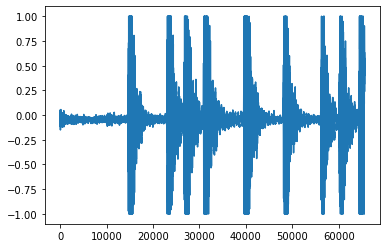

Saved! Filename:20200724154232.wav
Now Recording...
finished!


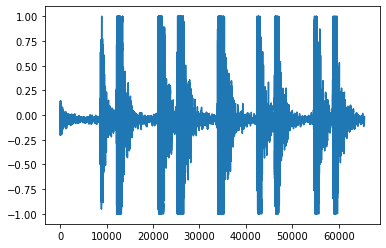

Saved! Filename:20200724154238.wav
Now Recording...
finished!


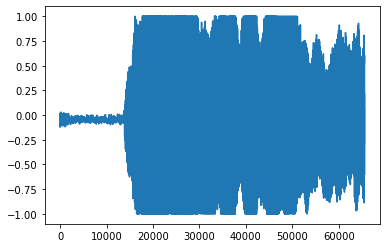

Saved! Filename:20200724154247.wav
Exit recording mode.


In [4]:
#録音モード動作
Recoder = Audio_Recoder(bitrate,sr,rec_length,a_index,save_dir)
key = ""
while key =="0"or"1":
    key = input("Do you want to record? [0:yes 1:no]")
    if key =="0":
        Recoder.exec()
    elif key =="1":
        print("Exit recording mode.")
        break
del key,Recoder


## わかったこと
- 狙い踊りの機能は一通り実装
- 0を押し続ける限り何回も録音する->現場は0しか押す必要がない

## 次にやること
- Congigparserを使い、iniファイルに設定を保持する
    - 初回記号時にiniファイルの有無を探し、なければ生成
    - オーディオインデックスの初期値は`none`にしておき、初の環境では強制的にオーディオインデックス選択させる
    - 二回目以後はiniを読み込む。変更したいときは専用のモードで書き込ませる(CUIの設計しなきゃ…)